# <font color = purple> 2023 Synopsys ARC AIoT Design Contest - Knowledge Distillation </font>

# Knowledge Distillation & Model Fractionation

In [1]:
import os
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation, Softmax, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Layer, Flatten, Dense, Dropout, add
from tensorflow.keras.utils import to_categorical

2023-07-08 18:24:52.955175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
!nvidia-smi

Sat Jul  8 18:24:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 31%   29C    P8     9W / 250W |      7MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:82:00.0 Off |                  N/A |
| 34%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


2023-07-08 18:24:54.241103: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-07-08 18:24:54.354367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-08 18:24:54.354779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-07-08 18:24:54.355125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:82:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBand

## <font color = navy> Configurations </font>

In [4]:
class Config():
    # Data path
    IMAGE_DIR = "./train_img"
    LABEL_DIR = "./train_label/label.csv"
    
    # Degree unit
    DEG_UNIT = 5
    
    #  Dataloader parameters
    SPLIT = 0.2
    
    # Batch size
    BATCH_SIZE = 6 #16 #8
    
    # Image size
    IMG_HEIGHT = 224 #224
    IMG_WIDTH = 224 #224
    
    # Model parameters
    NUM_CLASSES = int(360 / DEG_UNIT)
    IN_CHANNEL = 1
    INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IN_CHANNEL)
    
    # Learning parameters
    lr = 1e-3
    num_epochs = 30 # 20 #30
    teacher_loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    student_loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    distill_loss_func = keras.losses.KLDivergence()
    loss_func = "categorical_crossentropy"
    
    # Optimizer parameters
    opt = 'adam'
    
    # Distiller parameters
    alpha = 0.1      # weight to student_loss_fn and 1-alpha to distill_loss_func
    temperature = 3  # Temperature for softening probability distributions. Larger temperature gives softer distributions.
    
    # Model
    NUM_STAGE = 4
    model_names = ['MobileNetV2-base', 'MobileNetV2-small', 'MobileNetV2-tiny', 'MobileNetV2-micro']
    model_archs = ['base', 'small', 'tiny', 'micro']
    models = [None] * NUM_STAGE
    trainableParams = [None] * NUM_STAGE
    nonTrainableParams = [None] * NUM_STAGE
    totalParams = [None] * NUM_STAGE
    

## <font color = navy> Load and Preprocess Dataset </font>

In [5]:
def load_data(img_path, lab_path, split=0.2):
    img_files = sorted(glob.glob(img_path + "/*"), key=os.path.getmtime) # Sort by time
    lab_df = pd.read_csv(lab_path)['class'].to_numpy() # Read label from csv
    data_x = []
    data_y = []
    
    # Concatenate images & labels
    for idx, img_file in enumerate(img_files):
        # image
        img = Image.open(img_file)
        img = img.convert('L') # Convert to gray
        img = np.array(img, dtype=int)
        img = img - 128.0 # Normalize
        
        # label
        lab = np.array(lab_df[idx], dtype=int)
        lab = np.expand_dims(lab, axis=0)
        
        data_x.append(img)
        data_y.append(lab)
    
    # Train & test split
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=split, random_state=42, shuffle=True)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

In [6]:
# Loading the dataset
X_train, X_test, y_train, y_test = load_data(Config.IMAGE_DIR, Config.LABEL_DIR)

## <font color = navy> Show Data </font>

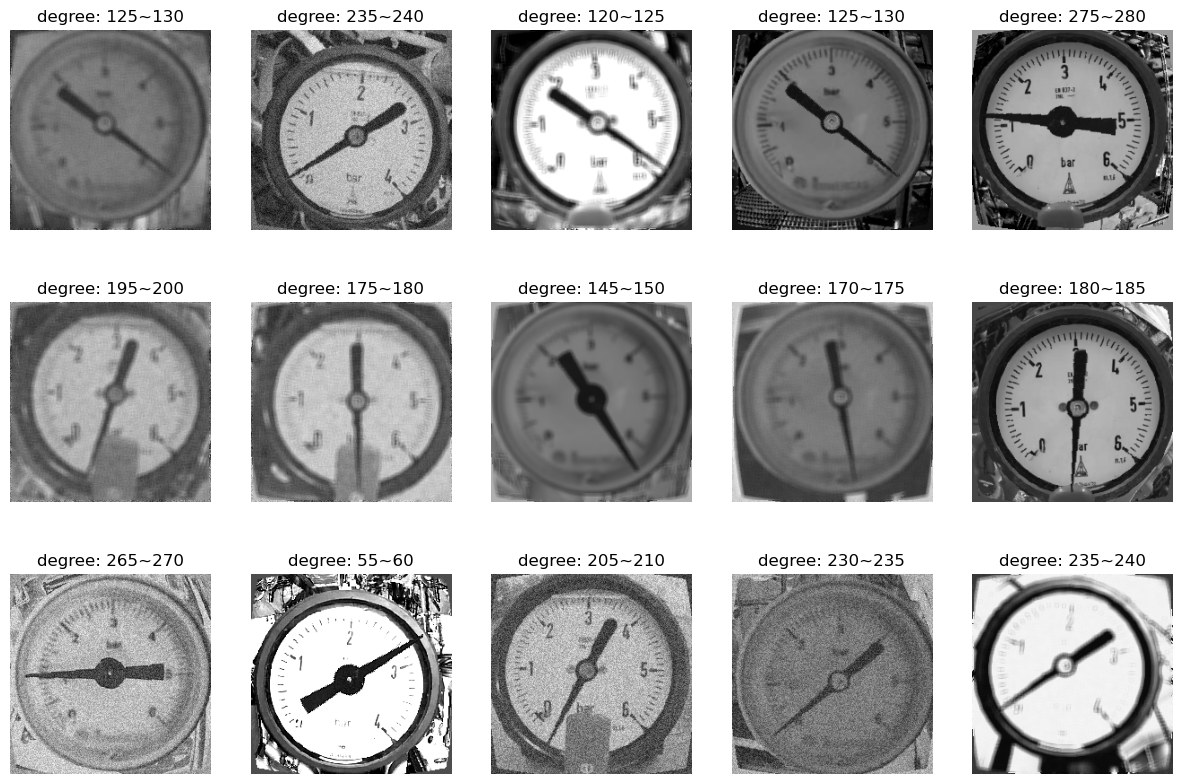

In [7]:
fig = plt.figure(figsize=(15,10))
for i in range(15):  
    ax = fig.add_subplot(3, 5, i+1)
    img = Image.fromarray(np.uint8(X_train[i] + 128)) # *255
    img = img.convert('RGBA')
    
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    lab = np.squeeze(y_train[i])
    lower = lab * Config.DEG_UNIT
    upper = (lab+1) * Config.DEG_UNIT
    ax.set_title('degree: {y1}~{y2}'.format(y1=lower, y2=upper))
    plt.axis('off')

## <font color = navy> One-hot encoding </font>

In [8]:
# y_train = to_categorical(y_train, Config.NUM_CLASSES)
# y_test = to_categorical(y_test, Config.NUM_CLASSES)

In [9]:
print("y_train: \n", y_train)
print("\n")
print("y_test: \n", y_test)

y_train: 
 [[25]
 [47]
 [24]
 ...
 [59]
 [71]
 [47]]


y_test: 
 [[59]
 [16]
 [ 8]
 ...
 [47]
 [18]
 [29]]


## <font color = navy> Reshape Images </font>

In [10]:
# Reshape
X_train = X_train.reshape(-1, Config.IMG_HEIGHT, Config.IMG_WIDTH, 1)
X_test = X_test.reshape(-1, Config.IMG_HEIGHT, Config.IMG_WIDTH, 1)

## <font color = navy> Build Models </font>

### <font color = red> Build Model: MobileNetV2 </font>

In [11]:
def expansion_block(x, t, filters, block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filter = t*filters
    x = Conv2D(total_filter, 1, padding='same',use_bias=False, name=prefix+'expand')(x)
    x = BatchNormalization(name=prefix+'expand_bn')(x)
    x = ReLU(6, name=prefix+'expand_relu')(x) # ReLU 6
    
    return x

def depthwise_block(x, stride, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3, strides=(stride,stride), padding='same', use_bias=False, name=prefix +'depthwise_conv')(x)
    x = BatchNormalization(name=prefix+'dw_bn')(x)
    x = ReLU(6,name=prefix+'dw_relu')(x)
    
    return x

def projection_block(x, out_channels, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False, name=prefix+'compress')(x)
    x = BatchNormalization(name=prefix+'compress_bn')(x)
    
    return x

In [12]:
def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    
    if y.shape[-1]==x.shape[-1]:
        y = add([x,y])
    return y

In [13]:
def MobileNetV2(input_image=Config.INPUT_SHAPE, n_classes=Config.NUM_CLASSES, arch='base'):
    if arch == 'base':
        input = Input(input_image)

        x = Conv2D(32,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=16,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 1280, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'small':
        input = Input(input_image)

        x = Conv2D(16,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=8,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 640, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'tiny':
        input = Input(input_image)

        x = Conv2D(8,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 6, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 6, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 320, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'micro':
        input = Input(input_image)

        x = Conv2D(4,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 160 , kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model

In [14]:
for i in range(Config.NUM_STAGE):
    print('[' + Config.model_names[i] + ']')
    Config.models[i] = MobileNetV2(arch=Config.model_archs[i])
    Config.trainableParams[i] = np.sum([np.prod(v.get_shape()) for v in Config.models[i].trainable_weights])
    Config.nonTrainableParams[i] = np.sum([np.prod(v.get_shape()) for v in Config.models[i].non_trainable_weights])
    Config.totalParams[i] = Config.trainableParams[i] + Config.nonTrainableParams[i]
    print('Trainable Prameters: ', Config.trainableParams[i])
    print('Non-trainable Parameters: ', Config.nonTrainableParams[i])
    print('Total Parameters: ', Config.totalParams[i])
    # Config.models[i].summary()
    print('-------------------------------------------------')

[MobileNetV2-base]


2023-07-08 18:25:11.387212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 18:25:11.990769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-08 18:25:11.991038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-07-08 18:25:11.991278: I tensorflow/core/common_runtime/gpu/gpu_devi

Trainable Prameters:  2315528
Non-trainable Parameters:  34112
Total Parameters:  2349640
-------------------------------------------------
[MobileNetV2-small]
Trainable Prameters:  626632
Non-trainable Parameters:  17056
Total Parameters:  643688
-------------------------------------------------
[MobileNetV2-tiny]
Trainable Prameters:  180560
Non-trainable Parameters:  8528
Total Parameters:  189088
-------------------------------------------------
[MobileNetV2-micro]
Trainable Prameters:  57394
Non-trainable Parameters:  4316
Total Parameters:  61710
-------------------------------------------------


## <font color = navy> Distiller </font>

In [15]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## <font color = navy> Create Teacher Model </font>

In [16]:
teacher = Config.models[0]

In [17]:
teacher.compile(
    optimizer=Config.opt,
    loss=Config.teacher_loss_func,
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

## <font color = navy> Create Student Model </font>

In [18]:
student = Config.models[3]

In [19]:
student.compile(
    optimizer=Config.opt,
    loss=Config.teacher_loss_func,
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

## <font color = navy> Save & Load for Copy Student Model </font>

In [20]:
student.save('student')
student = keras.models.load_model("student")
copy_student = keras.models.load_model("student")

2023-07-08 18:25:24.248400: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/bakerchen/.conda/envs/2023ARC/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: student/assets


In [21]:
# Clone student for later comparison
student_scratch = copy_student

## <font color = navy> Train Teacher Model </font>

In [22]:
# Train and evaluate teacher on data.
teacher_history = teacher.fit(X_train, y_train,
                              validation_split=0.2,
                              batch_size=Config.BATCH_SIZE,
                              verbose=1,
                              epochs=Config.num_epochs)

2023-07-08 18:25:49.707876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-08 18:25:49.726794: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999990000 Hz


Epoch 1/30


/home/bakerchen/.conda/envs/2023ARC/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2023-07-08 18:25:53.328612: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-07-08 18:25:54.210834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8700
2023-07-08 18:25:54.909074: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-08 18:25:54.909121: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-07-08 18:25:54.910286: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-08 18:25:54.910385:

1067/1067 [==============================] - 77s 66ms/step - loss: 4.3827 - sparse_categorical_accuracy: 0.0152 - val_loss: 4.3206 - val_sparse_categorical_accuracy: 0.0100
Epoch 2/30
1067/1067 [==============================] - 69s 64ms/step - loss: 4.3022 - sparse_categorical_accuracy: 0.0122 - val_loss: 4.3014 - val_sparse_categorical_accuracy: 0.0137
Epoch 3/30
1067/1067 [==============================] - 67s 62ms/step - loss: 4.2828 - sparse_categorical_accuracy: 0.0177 - val_loss: 4.1571 - val_sparse_categorical_accuracy: 0.0188
Epoch 4/30
1067/1067 [==============================] - 67s 63ms/step - loss: 3.0472 - sparse_categorical_accuracy: 0.1078 - val_loss: 2.1854 - val_sparse_categorical_accuracy: 0.1725
Epoch 5/30
1067/1067 [==============================] - 70s 65ms/step - loss: 2.1075 - sparse_categorical_accuracy: 0.2138 - val_loss: 1.7125 - val_sparse_categorical_accuracy: 0.3300
Epoch 6/30
1067/1067 [==============================] - 69s 65ms/step - loss: 1.6048 - spar

### <font color = red> Evaluation: Teacher Model </font>

In [23]:
teacher_score = teacher.evaluate(X_test, y_test, verbose=0)
print(teacher_score)

[0.41944271326065063, 0.8295000195503235]


## <font color = navy> Distill Teacher to Student </font>

In [24]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=Config.opt,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=Config.student_loss_func,
    distillation_loss_fn=Config.distill_loss_func,
    alpha=Config.alpha,
    temperature=Config.temperature,
)

In [25]:
# Distill teacher to student
distiller_history = distiller.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=Config.BATCH_SIZE,
    verbose=1,
    epochs=Config.num_epochs)

Epoch 1/30
1067/1067 [==============================] - 77s 67ms/step - sparse_categorical_accuracy: 0.0289 - student_loss: 4.0994 - distillation_loss: 0.0068 - val_sparse_categorical_accuracy: 0.0487 - val_student_loss: 3.4394
Epoch 2/30
1067/1067 [==============================] - 71s 66ms/step - sparse_categorical_accuracy: 0.1114 - student_loss: 2.9753 - distillation_loss: 0.0064 - val_sparse_categorical_accuracy: 0.2113 - val_student_loss: 2.0617
Epoch 3/30
1067/1067 [==============================] - 69s 65ms/step - sparse_categorical_accuracy: 0.1920 - student_loss: 2.3097 - distillation_loss: 0.0059 - val_sparse_categorical_accuracy: 0.2931 - val_student_loss: 1.4914
Epoch 4/30
1067/1067 [==============================] - 71s 66ms/step - sparse_categorical_accuracy: 0.3016 - student_loss: 1.8758 - distillation_loss: 0.0053 - val_sparse_categorical_accuracy: 0.4550 - val_student_loss: 1.2604
Epoch 5/30
1067/1067 [==============================] - 67s 63ms/step - sparse_categoric

### <font color = red> Evaluation: Distiller Student Model </font>

In [26]:
# Evaluate student on test dataset
distiller_score = distiller.evaluate(X_test, y_test, verbose=0)
print(distiller_score)

[0.7544999718666077, 0.36490368843078613]


In [27]:
student_score = student.evaluate(X_test, y_test, verbose=0)
print(student_score)

[0.6281920671463013, 0.7544999718666077]


## <font color = navy> Train Original Student Model </font>

In [28]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=Config.student_loss_func,
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [29]:
# Train and evaluate student trained from scratch.
student_scratch_history = student_scratch.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=Config.BATCH_SIZE,
    verbose=1,
    epochs=Config.num_epochs)

Epoch 1/30
1067/1067 [==============================] - 56s 48ms/step - loss: 4.3350 - sparse_categorical_accuracy: 0.0131 - val_loss: 4.4808 - val_sparse_categorical_accuracy: 0.0181
Epoch 2/30
1067/1067 [==============================] - 53s 49ms/step - loss: 3.7172 - sparse_categorical_accuracy: 0.0572 - val_loss: 3.7425 - val_sparse_categorical_accuracy: 0.0319
Epoch 3/30
1067/1067 [==============================] - 51s 48ms/step - loss: 2.7000 - sparse_categorical_accuracy: 0.1386 - val_loss: 2.1173 - val_sparse_categorical_accuracy: 0.2163
Epoch 4/30
1067/1067 [==============================] - 51s 48ms/step - loss: 2.1100 - sparse_categorical_accuracy: 0.2498 - val_loss: 1.6170 - val_sparse_categorical_accuracy: 0.3669
Epoch 5/30
1067/1067 [==============================] - 50s 47ms/step - loss: 1.6150 - sparse_categorical_accuracy: 0.3858 - val_loss: 1.1979 - val_sparse_categorical_accuracy: 0.4869
Epoch 6/30
1067/1067 [==============================] - 52s 49ms/step - loss: 1.

### <font color = red> Evaluation: Original Student Model </font>

In [30]:
student_scratch_score = student_scratch.evaluate(X_test, y_test, verbose=0)
print(student_scratch_score)

[0.3783220052719116, 0.8335000276565552]


## <font color = navy> Save & Load Teacher model </font>

In [31]:
teacher.save('teacher')

/home/bakerchen/.conda/envs/2023ARC/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: teacher/assets


In [32]:
teacher = keras.models.load_model("teacher")

## <font color = navy> Proposed Method: Model Fractionation </font>

In [ ]:
# def fractionizer(models, stages):
#     for i in range(len(models)):
#         print('Stage ', i)
        
